## Ex3 - Autoencoders

In [1]:
%matplotlib inline

import helper
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Hyperparameters

In [2]:
epochs = 1000
batch_size = 200
n_batches = 5
noise_factor = 35
learning_rate = 0.003
do_preprocess = False
show_images_every_n_epochs = 100

### Prepare the dataset

In [3]:
cifar10_dataset_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

helper.download_dataset(cifar10_dataset_url, cifar10_dataset_folder_path, tar_gz_path) 
if do_preprocess:
    helper.preprocess_and_save_data(cifar10_dataset_folder_path, noise_factor, n_batches)

Cifar-10 dataset found


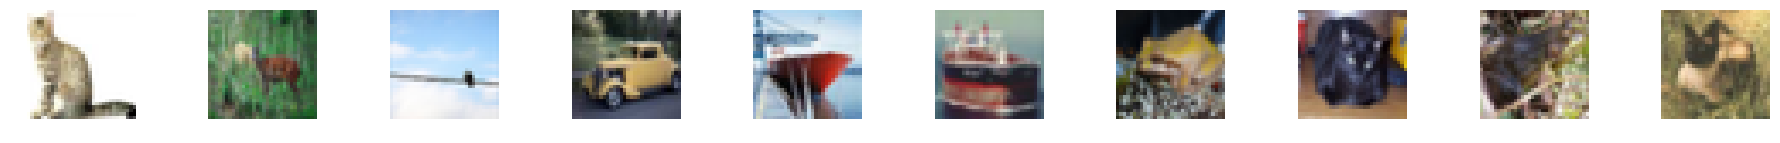

In [4]:
features, _ = helper.load_cfar10_batch(cifar10_dataset_folder_path, random.randint(1, n_batches))
valid_features, valid_noisy, _ = helper.load_preprocess_validation()[:10]
test_features, test_noisy, _ = helper.load_preprocess_testing()

plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(features[i + random.randint(0, len(features) - 10)])

### Build the network

In [5]:
inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

In [6]:
def unpool(value, name='unpool'):
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, tf.zeros_like(out)], i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

def conv2d_maxpool(x_tensor, conv_num_outputs):
    weight = tf.Variable(tf.truncated_normal([3, 3, x_tensor.shape[3].value, conv_num_outputs], stddev=0.1))
    conv_layer = tf.nn.conv2d(x_tensor, weight, [1, 1, 1, 1], 'SAME')
    conv_layer = tf.nn.bias_add(conv_layer, tf.Variable(tf.zeros(conv_num_outputs)))
    conv_layer = tf.nn.relu(conv_layer)
    conv_layer = tf.nn.max_pool(conv_layer, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    return conv_layer

In [7]:
print('encoder')
print(inputs_.get_shape())
conv1 = tf.layers.conv2d(inputs_, 6, (3,3), padding='same', activation=tf.nn.relu)
print(conv1.get_shape())
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
print(maxpool1.get_shape())
conv2 = tf.layers.conv2d(maxpool1, 12, (3,3), padding='same', activation=tf.nn.relu)
print(conv2.get_shape())
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
print(maxpool2.get_shape())
conv3 = tf.layers.conv2d(maxpool2, 24, (3,3), padding='same', activation=tf.nn.relu)
print(conv3.get_shape())
maxpool3 = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
print(maxpool3.get_shape())
conv4 = tf.layers.conv2d(maxpool3, 48, (3,3), padding='same', activation=tf.nn.relu)
print(conv4.get_shape())
maxpool4 = tf.layers.max_pooling2d(conv4, (2,2), (2,2), padding='same')
print(maxpool4.get_shape())
encoded = tf.layers.conv2d(maxpool4, 96, (3,3), padding='same', activation=tf.nn.relu)
print(encoded.get_shape())
print
print('decoder')
upsample1 = tf.image.resize_nearest_neighbor(encoded, (2,2))
print(upsample1.get_shape())
conv4 = tf.layers.conv2d(upsample1, 48, (3,3), padding='same', activation=tf.nn.relu)
print(conv4.get_shape())
upsample2 = tf.image.resize_nearest_neighbor(conv4, (4,4))
print(upsample2.get_shape())
conv5 = tf.layers.conv2d(upsample2, 24, (3,3), padding='same', activation=tf.nn.relu)
print(conv5.get_shape())
upsample3 = tf.image.resize_nearest_neighbor(conv5, (8,8))
print(upsample3.get_shape())
conv6 = tf.layers.conv2d(upsample3, 12, (3,3), padding='same', activation=tf.nn.relu)
print(conv6.get_shape())
upsample4 = tf.image.resize_nearest_neighbor(conv6, (16,16))
print(upsample4.get_shape())
conv7 = tf.layers.conv2d(upsample4, 6, (3,3), padding='same', activation=tf.nn.relu)
print(conv7.get_shape())
upsample5 = tf.image.resize_nearest_neighbor(conv7, (32,32))
print(upsample5.get_shape())
logits = tf.layers.conv2d(upsample5, 3, (3,3), padding='same', activation=tf.nn.relu)
print(logits.get_shape())

y_pred = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

encoder
(?, 32, 32, 3)
(?, 32, 32, 6)
(?, 16, 16, 6)
(?, 16, 16, 12)
(?, 8, 8, 12)
(?, 8, 8, 24)
(?, 4, 4, 24)
(?, 4, 4, 48)
(?, 2, 2, 48)
(?, 2, 2, 96)

decoder
(?, 2, 2, 96)
(?, 2, 2, 48)
(?, 4, 4, 48)
(?, 4, 4, 24)
(?, 8, 8, 24)
(?, 8, 8, 12)
(?, 16, 16, 12)
(?, 16, 16, 6)
(?, 32, 32, 6)
(?, 32, 32, 3)


In [8]:
# print('encoder')
# print(inputs_.get_shape())
# encoder_layer1 = tf.layers.conv2d(inputs_, 8, [5, 5], strides=(1, 1), padding="SAME")
# print(encoder_layer1.get_shape())
# pool_encoder_layer1 = tf.layers.max_pooling2d(encoder_layer1, pool_size=(2, 2), strides=(2, 2), padding="SAME")
# print(pool_encoder_layer1.get_shape())
# encoder_layer2 = tf.layers.conv2d(pool_encoder_layer1, 16, [5, 5], strides=(1, 1), padding="SAME")
# print(encoder_layer2.get_shape())
# pool_encoder_layer2 = tf.layers.max_pooling2d(encoder_layer2, pool_size=(2, 2), strides=(2, 2), padding="SAME")
# print(pool_encoder_layer2.get_shape())
# encoder_layer3 = tf.layers.conv2d(pool_encoder_layer2, 32, [5, 5], strides=(4, 4), padding="SAME")
# print(encoder_layer3.get_shape())
# print
# print('decoder')
# decoder_layer1 = tf.layers.conv2d_transpose(encoder_layer3, 32, [5, 5], strides=(4, 4), padding="SAME")
# print(decoder_layer1.get_shape())
# unpool_decoder_layer2 = unpool(decoder_layer1)
# print(unpool_decoder_layer2.get_shape())
# decoder_layer2 = tf.layers.conv2d_transpose(unpool_decoder_layer2, 16, [5, 5], strides=(1, 1), padding="SAME")
# print(decoder_layer2.get_shape())
# unpool_decoder_layer3 = unpool(decoder_layer2)
# print(unpool_decoder_layer3.get_shape())
# decoder_layer3 = tf.layers.conv2d_transpose(unpool_decoder_layer3, 3, [5, 5], strides=(1, 1), padding="SAME")
# print(decoder_layer3.get_shape())

# y_pred = tf.identity(decoder_layer3)

# cost = tf.reduce_mean(tf.squared_difference(y_pred, targets_))
# opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [9]:
# print('encoder')
# print(inputs_.get_shape())
# encoder = conv2d_maxpool(inputs_, 24)
# print(encoder.get_shape())
# encoder = conv2d_maxpool(encoder, 192)
# print(encoder.get_shape())
# encoder = conv2d_maxpool(encoder, 1536)
# print(encoder.get_shape())
# print
# print('decoder')
# decoder = tf.layers.conv2d_transpose(encoder, 1536, [5, 5], strides=(1, 1), padding="SAME")
# print(decoder.get_shape())
# decoder = unpool(decoder)
# print(decoder.get_shape())
# decoder = tf.layers.conv2d_transpose(decoder, 192, [5, 5], strides=(1, 1), padding="SAME")
# print(decoder.get_shape())
# decoder = unpool(decoder)
# print(decoder.get_shape())
# decoder = tf.layers.conv2d_transpose(decoder, 24, [5, 5], strides=(1, 1), padding="SAME")
# print(decoder.get_shape())
# decoder = unpool(decoder)
# print(decoder.get_shape())
# decoder = tf.layers.conv2d_transpose(decoder, 3, [5, 5], strides=(1, 1), padding="SAME")
# print(decoder.get_shape())

# y_pred = tf.identity(decoder)

# cost = tf.reduce_mean(tf.squared_difference(y_pred, targets_))
# opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Train the network

In [10]:
sess = tf.Session()

In [11]:
print('Training...')
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, n_batches + 1):
        for features, noisy_features, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_features, targets_: features})
    print("Epoch: {}/{}...".format(e + 1, epochs), "Training loss: {:.4f}".format(batch_cost))
    if e % show_images_every_n_epochs:
        reconstructed = sess.run(y_pred, feed_dict={inputs_: valid_noisy[:10].reshape((10, 32, 32, 3))})
        helper.show_images(valid_features, valid_noisy, np.clip(reconstructed, 0, 1))

Training...
('Epoch: 1/1...', 'Training loss: 0.6553')


### Test the network

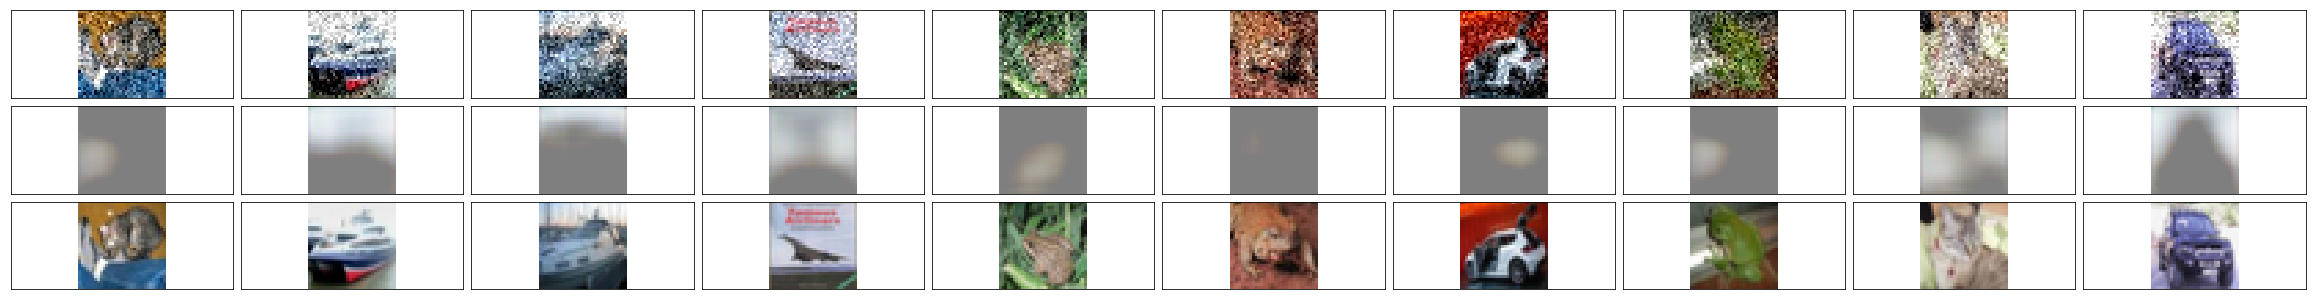

In [13]:
test_features = test_features[:10]
test_noisy = test_noisy[:10]

reconstructed = sess.run(y_pred, feed_dict={inputs_: test_noisy.reshape((10, 32, 32, 3))})

helper.show_images(test_features, test_noisy, np.clip(reconstructed, 0, 1))